# MAG Analysis

Data from the [Rothman study](https://doi.org/10.1128/AEM.01448-21) corresponding to (unenriched) samples from the [HTP site](https://en.wikipedia.org/wiki/Hyperion_sewage_treatment_plant) was downloaded from the [ENA](https://www.ebi.ac.uk/ena/browser/view/prjna729801) and processed using the [nf-core/mag](https://github.com/PhilPalmer/mag/tree/genomad) pipeline to generate assembled and binned metagenomes (as shown by the image below). Here, we will analyse the results generated by the pipeline. First, we will load and aggregate the pipeline results, explaining the steps along the way. Then, we will use the aggregated results to answer some key questions about the data such as what organisms are present in the samples and how do the taxonomic classifications generated using the reads and the assembled genomes compare.

<img src="https://raw.githubusercontent.com/nf-core/mag/master/docs/images/mag_workflow.png" width="1000">


In [160]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import plotly.express as px
import seaborn as sns
import shutil
import yaml

from Bio import SeqIO
from matplotlib import rcParams
# from matplotlib import colors as mcolors

In [161]:
########
# Change
########
# TODO: Upload directory to AWS S3 and add code to download the data if needed
data_dir = '../mag/results_rothman_htp'

##############
# Don't change
##############

# QC
fastqc_yaml = f'{data_dir}/multiqc/multiqc_data/multiqc_fastqc.yaml'

# Assembly data
bam_dir = f'{data_dir}/Assembly/SPAdes/QC/group-HTP'

# Genome Binning data
binner = 'MaxBin2'
busco_tsv = f'{data_dir}/GenomeBinning/QC/busco_summary.tsv'
quast_tsv = f'{data_dir}/GenomeBinning/QC/quast_summary.tsv'
bin_tsv = f'{data_dir}/GenomeBinning/bin_summary.tsv'
bin_dir = f'{data_dir}/GenomeBinning/{binner}'

# Taxonomy data
kraken_dir = f'{data_dir}/Taxonomy/kraken2'
genomad_dir = f'{data_dir}/Taxonomy/geNomad'
genomad_class = f'{genomad_dir}/group-HTP/SPAdes-group-HTP_scaffolds_aggregated_classification/SPAdes-group-HTP_scaffolds_aggregated_classification.tsv'
genomad_tax = f'{genomad_dir}/group-HTP/SPAdes-group-HTP_scaffolds_annotate/SPAdes-group-HTP_scaffolds_taxonomy.tsv'
gtdbtk_tsv = f'{data_dir}/Taxonomy/GTDB-Tk/gtdbtk_summary.tsv'

In [162]:
# Define helper functions
def decompress_gz(gz_file):
    """
    Decompress a gzipped file.
    """
    file = gz_file.replace('.gz', '')
    if os.path.exists(gz_file) and not os.path.exists(file):
        !gzip -dk {gz_file}
    return file

## Load the data

We will load the data from the key steps of the pipeline in the rough order they ran.

We will load each contig and associate it with any relevant information such as the length, bin/MAG and coverage etc. As we have information at different levels (sample, assembly, MAG and taxonomic levels) we will use IDs to link information in different dataframes.


### Quality Control (QC)
The first step of the pipeline was to perform QC on the raw reads. Here we will load the data from [FastQC](https://github.com/s-andrews/FastQC)/[MultiQC](https://github.com/ewels/MultiQC) to obtain the sample names and the total number of raw reads per sample.

In [163]:
# Read the QC data
with open(fastqc_yaml, 'r') as f:
    fastqc_data = yaml.load(f, Loader=yaml.FullLoader)

# Get the sample IDs and the total number of raw reads
sample_read_counts = {k: fastqc_data[k]['Total Sequences'] for k in fastqc_data.keys()}
sample_read_counts = {k.replace('_1',''): int(sample_read_counts[k] + sample_read_counts[k.replace('_1', '_2')]) for k in sample_read_counts.keys() if '_1' in k}
samples = list(sample_read_counts.keys())
print(samples)

['SRR14530762', 'SRR14530763', 'SRR14530764', 'SRR14530765', 'SRR14530766', 'SRR14530767', 'SRR14530769', 'SRR14530770', 'SRR14530771', 'SRR14530772', 'SRR14530880', 'SRR14530881', 'SRR14530882', 'SRR14530884', 'SRR14530885', 'SRR14530886', 'SRR14530887', 'SRR14530888', 'SRR14530889', 'SRR14530890', 'SRR14530891']


### Assemblies

[metaSPAdes](http://cab.spbu.ru/software/spades/) was used for the assembly i.e. merging of reads.

(We will skip loading the contigs here because instead, we will load the MAGs (in the next step) which includes the same information for the contigs and additional information such as the bin).

#### Getting read counts for the contigs and samples

Here we will generate a count matrix i.e. a file mapping contig IDs (rows) and sample IDs (columns).

The nf-core/mag pipeline already maps the reads back to the contigs using [bowtie2](https://github.com/BenLangmead/bowtie2) (see [code](https://github.com/nf-core/mag/blob/master/modules/local/bowtie2_assembly_align.nf#L23-L30)). Therefore, we can use [samtools](http://www.htslib.org/) to get the read counts for each contig and sample (see [example](https://github.com/edamame-course/Metagenome/blob/master/2018-06-29-counting-abundance-with-mapped-reads.md#option-1-count-each-contigs)). The third column in the tab-seperated output from [`samtools idxstats`](http://www.htslib.org/doc/samtools-idxstats.html) is the number of reads mapped to the contig which we'll use to generate the count matrix.

In [164]:
# Get absolute path for bam_dir and generate a list of all of the bams
bam_dir = os.path.abspath(bam_dir)
bams = [f'{bam_dir}/{bam}' for bam in os.listdir(bam_dir) if bam.endswith('.bam')]

# Check if samtools is installed locally, if not, use the docker container from the nf-core/mag pipeline to run samtools
if shutil.which('samtools'):
    samtools_cmd = 'samtools'
else:
    samtools_cmd = f'docker run -v {bam_dir}:{bam_dir} -w {bam_dir} quay.io/biocontainers/mulled-v2-ac74a7f02cebcfcc07d8e8d1d750af9c83b4d45a:577a697be67b5ae9b16f637fd723b8263a3898b3-0 samtools'

# Run samtools idxstats on all of the bams
for bam in bams:
    sample = bam.split('/')[-1].split('.')[0].split('-')[-1]
    if not os.path.exists(f'{bam_dir}/{sample}_idxstats.txt'):
        !{samtools_cmd} idxstats {bam} > {bam_dir}/{sample}_idxstats.txt

In [165]:
# Load and concatenate the idxstats files
idxstat_cols = ['contig', 'length', 'num_mapped_reads', 'num_unmapped_reads']
idxstat_dfs = []

# Get a list of all of the idxstats files
idxstats = [f'{bam_dir}/{idxstat}' for idxstat in os.listdir(bam_dir) if idxstat.endswith('_idxstats.txt')]

# Read in the idxstats files
for idxstat in idxstats:
    sample = idxstat.split('/')[-1].split('_')[0]
    idxstat_df = pd.read_csv(idxstat, sep='\t', header=None, names=idxstat_cols)
    idxstat_df['sample_id'] = sample
    idxstat_dfs.append(idxstat_df)

# Combine the idxstats dataframes into a single dataframe
counts_df = pd.concat(idxstat_dfs, axis=0)
counts_df.contig = counts_df.contig.str.split('_').str[1]

In [166]:
# Reformat the dataframe so that the contigs are the index and the samples are the columns
counts_df = counts_df.pivot(index='contig', columns='sample_id', values='num_mapped_reads')

# Sort the dataframe
counts_df = counts_df[~counts_df.index.isnull()]
counts_df.index = counts_df.index.astype(int)
counts_df = counts_df.sort_index()

counts_df

sample_id,SRR14530762,SRR14530763,SRR14530764,SRR14530765,SRR14530766,SRR14530767,SRR14530769,SRR14530770,SRR14530771,SRR14530772,SRR14530880,SRR14530881,SRR14530882,SRR14530884,SRR14530885,SRR14530886,SRR14530887,SRR14530888,SRR14530889,SRR14530890,SRR14530891
contig,,,,,,,,,,,,,,,,,,,,,
1,275,82530,53032,147716,38879,45504,54,140077,42910,180458,3828,3337,78,54,69,22,244,1345,63,3800,55
2,212,48783,29318,82814,22091,27356,18,88222,26642,104245,6308,4806,101,89,129,35,295,1799,212,7539,131
3,215,45422,27606,77845,20311,24449,40,79974,24234,95958,3348,2824,47,41,66,16,199,967,56,3276,60
4,142,38251,23128,65595,16718,19946,26,69111,20329,80653,2399,1972,36,32,51,13,159,706,31,2316,29
5,93,31235,19934,55046,14674,17176,18,51560,15991,68057,2112,2125,21,11,30,5,93,717,29,2578,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164662,0,0,0,0,0,0,0,0,0,0,1,0,3,1,3,24,0,0,0,1,1
164663,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,4,2,2,2
164664,11,6,9,3,12,10,13,4,1,8,33,18,50,34,24,34,52,17,12,21,43


### Genome binning

Here we will load the bins/MAGs

- Two tools were used to perform metagenome binning to generate metagenome assembled genomes (MAGs) - [MetaBAT2](https://bitbucket.org/berkeleylab/metabat/src/master/) and [MaxBin2](https://sourceforge.net/projects/maxbin2/)

- And two tools were used to check for quality control (QC) of the genome bins - [Busco](https://busco.ezlab.org/) and [Quast](http://quast.sourceforge.net/quast)


Let's look the summary information of the bins/MAGs


In [167]:
pd.set_option('display.max_columns', None)

bin_summary_df = pd.read_csv(bin_tsv, sep='\t', index_col=0)
bin_summary_df.head()

,bin,Depth SRR14530762,Depth SRR14530763,Depth SRR14530764,Depth SRR14530765,Depth SRR14530766,Depth SRR14530767,Depth SRR14530769,Depth SRR14530770,Depth SRR14530771,Depth SRR14530772,Depth SRR14530880,Depth SRR14530881,Depth SRR14530882,Depth SRR14530884,Depth SRR14530885,Depth SRR14530886,Depth SRR14530887,Depth SRR14530888,Depth SRR14530889,Depth SRR14530890,Depth SRR14530891,GenomeBin,Domain,%Complete (domain),%Complete and single-copy (domain),%Complete and duplicated (domain),%Fragmented (domain),%Missing (domain),Total number (domain),Specific lineage dataset,%Complete (specific),%Complete and single-copy (specific),%Complete and duplicated (specific),%Fragmented (specific),%Missing (specific),Total number (specific),Assembly,# contigs (>= 0 bp),# contigs (>= 1000 bp),# contigs (>= 5000 bp),# contigs (>= 10000 bp),# contigs (>= 25000 bp),# contigs (>= 50000 bp),Total length (>= 0 bp),Total length (>= 1000 bp),Total length (>= 5000 bp),Total length (>= 10000 bp),Total length (>= 25000 bp),Total length (>= 50000 bp),# contigs,Largest contig,Total length,GC (%),N50,N75,L50,L75,# N's per 100 kbp,# predicted rRNA genes
0,SPAdes-MetaBAT2-group-HTP.1.fa,0.066717,23.853900,13.459800,42.154750,10.773450,12.801900,0.002138,36.670650,10.353300,47.135250,0.738708,0.704969,0.004422,0.002262,0.009820,0.000000,0.040139,0.309518,0.005733,0.71272,0.000624,SPAdes-MetaBAT2-group-HTP.1.fa,bacteria_odb10,92.7,91.1,1.6,0.0,7.3,124,burkholderiales_odb10,93.3,92.9,0.4,1.2,5.5,688.0,SPAdes-MetaBAT2-group-HTP.1.fa,54,54,45,42,31,20,3350955,3350955,3325616,3305081,3114481,2679124,54,429168,3350955,58.16,135708,62821,9,18,20.89,0 + 0 part
1,SPAdes-MaxBin2-group-HTP.001.fa,0.976038,0.780799,0.778258,0.558656,0.494961,0.633394,0.576577,0.502917,0.310078,0.444209,2.978460,3.246240,2.508980,1.838410,2.215040,0.341278,2.808960,2.571970,2.603950,2.94920,2.294050,SPAdes-MaxBin2-group-HTP.001.fa,bacteria_odb10,10.5,9.7,0.8,0.8,88.7,124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SPAdes-MaxBin2-group-HTP.001.fa,917,917,36,0,0,0,1736869,1736869,237600,0,0,0,917,9237,1736869,46.08,1917,1327,258,534,11.51,3 + 33 part
2,SPAdes-MaxBin2-group-HTP.002.fa,0.368126,1.556870,1.357770,0.665245,0.527326,0.434845,0.108499,1.027780,0.423746,0.643511,0.788409,0.861916,0.400835,0.371324,0.435829,0.000000,0.606955,0.514989,0.304249,1.18904,0.224944,SPAdes-MaxBin2-group-HTP.002.fa,bacteria_odb10,99.2,91.1,8.1,0.0,0.8,124,betaproteobacteria_odb10,98.6,97.7,0.9,0.4,1.0,569.0,SPAdes-MaxBin2-group-HTP.002.fa,963,963,95,45,32,20,5176992,5176992,3676500,3367432,3150489,2679124,963,429168,5176992,56.92,58262,3791,19,143,19.32,2 + 34 part


The results from the tools show that MaxBin2 generated more genome bins and a higher % completeness than MetaBAT2


In [168]:
busco_df = pd.read_csv(busco_tsv, sep='\t')
busco_df.head()

,GenomeBin,Domain,%Complete (domain),%Complete and single-copy (domain),%Complete and duplicated (domain),%Fragmented (domain),%Missing (domain),Total number (domain),Specific lineage dataset,%Complete (specific),%Complete and single-copy (specific),%Complete and duplicated (specific),%Fragmented (specific),%Missing (specific),Total number (specific)
0,SPAdes-MaxBin2-group-HTP.002.fa,bacteria_odb10,99.2,91.1,8.1,0.0,0.8,124,betaproteobacteria_odb10,98.6,97.7,0.9,0.4,1.0,569.0
1,SPAdes-MetaBAT2-group-HTP.1.fa,bacteria_odb10,92.7,91.1,1.6,0.0,7.3,124,burkholderiales_odb10,93.3,92.9,0.4,1.2,5.5,688.0
2,SPAdes-MaxBin2-group-HTP.001.fa,bacteria_odb10,10.5,9.7,0.8,0.8,88.7,124,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [169]:
quast_df = pd.read_csv(quast_tsv, sep='\t')
quast_df.head()

,Assembly,# contigs (>= 0 bp),# contigs (>= 1000 bp),# contigs (>= 5000 bp),# contigs (>= 10000 bp),# contigs (>= 25000 bp),# contigs (>= 50000 bp),Total length (>= 0 bp),Total length (>= 1000 bp),Total length (>= 5000 bp),Total length (>= 10000 bp),Total length (>= 25000 bp),Total length (>= 50000 bp),# contigs,Largest contig,Total length,GC (%),N50,N75,L50,L75,# N's per 100 kbp,# predicted rRNA genes
0,SPAdes-MetaBAT2-group-HTP.1.fa,54,54,45,42,31,20,3350955,3350955,3325616,3305081,3114481,2679124,54,429168,3350955,58.16,135708,62821,9,18,20.89,0 + 0 part
1,SPAdes-MaxBin2-group-HTP.001.fa,917,917,36,0,0,0,1736869,1736869,237600,0,0,0,917,9237,1736869,46.08,1917,1327,258,534,11.51,3 + 33 part
2,SPAdes-MaxBin2-group-HTP.002.fa,963,963,95,45,32,20,5176992,5176992,3676500,3367432,3150489,2679124,963,429168,5176992,56.92,58262,3791,19,143,19.32,2 + 34 part


We will therefore use the MaxBin2 results for the rest of the analysis


In [170]:
# Get the bin files
bin_files = []

for dirpath, dirnames, filenames in os.walk(bin_dir):
    bin_files.extend([os.path.join(dirpath, file) for file in filenames if file.endswith('.gz')])

bin_files

['../mag/results_rothman_htp/GenomeBinning/MaxBin2/unbinned/discarded/SPAdes-MaxBin2-group-HTP.noclass.pooled.fa.gz',
 '../mag/results_rothman_htp/GenomeBinning/MaxBin2/unbinned/discarded/SPAdes-MaxBin2-group-HTP.noclass.remaining.fa.gz',
 '../mag/results_rothman_htp/GenomeBinning/MaxBin2/bins/SPAdes-MaxBin2-group-HTP.001.fa.gz',
 '../mag/results_rothman_htp/GenomeBinning/MaxBin2/bins/SPAdes-MaxBin2-group-HTP.002.fa.gz',
 '../mag/results_rothman_htp/GenomeBinning/MaxBin2/discarded/SPAdes-MaxBin2-group-HTP.tooshort.gz']

In [171]:
# Load the MAGs (i.e. contigs and bins) from the bin files into dataframes
bin_dfs = []

for bin_file_gz in bin_files:

    # Decompress (if they aren't already), then load the bin files as a dict {'node_id': ['length', 'cov', 'seq']} and convert to a dataframe
    bin_file = decompress_gz(bin_file_gz)
    bin_dict = {int(record.id.split('_')[1]): [int(record.id.split('_')[3]), float(record.id.split('_')[5]), str(record.seq)] for record in SeqIO.parse(bin_file, 'fasta')}
    bin_df = pd.DataFrame.from_dict(bin_dict, orient='index', columns=['length', 'coverage', 'seq'])

    # Add the bin ID to the dataframe
    bin_df['bin_id'] = bin_file.split('/')[-1].split('.')[1]

    # Add the dataframe to the list
    bin_dfs.append(bin_df)

# Concatenate all of the dataframes
bin_df = pd.concat(bin_dfs).sort_index()
bin_df = bin_df[~bin_df.index.duplicated(keep='first')]
bin_df.head()

,length,coverage,seq,bin_id
1,429168,132.214891,GACACCAGCAAGCGTCCGCCAAGCAAGCTTCTACGATCAAAAACTT...,002
2,214794,155.876023,CATTGGGCCCGGGGGGGGGCCACGCCCCCCCCAACCAAAAAACCGA...,002
3,204790,151.550375,GCCTGAACCTGAACATGCCGCTGTCCGATGAAATGAAGGCCTTGTA...,002
4,185392,139.905194,CCGTCAAAGAGCATCTGGTTCAGGCTCAGCACGTAGCCGCTTCGGT...,002
5,148022,144.176302,TGTCGCATGCGACAAGATCGGTACTCCCACAGGGGACTTTCACCCC...,002


### Taxonomic classification


#### Taxonomic classification of trimmed reads

The [kraken2](https://github.com/DerrickWood/kraken2/wiki/Manual) tool was used to classify trimmed reads using the [prebuilt 8GB minikraken DB](https://zenodo.org/record/4024003#.Y4-9PdLMK0o) as provided by the Center for Computational Biology of the John Hopkins University (from 2020-03). (**Note:** Using a larger kraken database would likely improve the results by decreasing the number of unclassified reads). The outputs were tab seperated files with the following columns:  

1. `percentage` - Percentage of fragments covered by the clade rooted at this taxon
2. `num_fragments` - Number of fragments covered by the clade rooted at this taxon
3. `num_assigned` - Number of fragments assigned directly to this taxon
4. `rank_code` - A rank code, indicating (U)nclassified, (R)oot, (D)omain, (K)ingdom, (P)hylum, (C)lass, (O)rder, (F)amily, (G)enus, or (S)pecies. Taxa that are not at any of these 10 ranks have a rank code that is formed by using the rank code of the closest ancestor rank with a number indicating the distance from that rank. E.g., "G2" is a rank code indicating a taxon is between genus and species and the grandparent taxon is at the genus rank.
5. `tax_id` NCBI taxonomic ID number
6. `scientific_name` - Indented scientific name

In [172]:
kraken_dfs = []
names = ['percentage', 'num_fragments', 'num_assigned', 'rank_code', 'tax_id', 'scientific_name']

for sample in samples:
    kraken_file = f'{kraken_dir}/{sample}/kraken2_report.txt'
    kraken_df = pd.read_csv(kraken_file, sep='\t', header=None, names=names, index_col=0)
    kraken_df['sample_id'] = sample
    kraken_dfs.append(kraken_df)

kraken_df = pd.concat(kraken_dfs)

# Remove whitespace from the scientific name
kraken_df.scientific_name = kraken_df.scientific_name.str.strip()
kraken_df = kraken_df.reset_index()
kraken_df.head()

,percentage,num_fragments,num_assigned,rank_code,tax_id,scientific_name,sample_id
0,49.65,1776130,1776130,U,0,unclassified,SRR14530762
1,50.35,1801248,430,R,1,root,SRR14530762
2,43.78,1566074,13020,R1,131567,cellular organisms,SRR14530762
3,42.81,1531604,298743,D,2,Bacteria,SRR14530762
4,22.46,803324,115323,P,1224,Proteobacteria,SRR14530762


In [173]:
# Define vars
cols = ['total_raw_reads', 'total_processed_reads', 'classified_reads', 'unclassified_reads', 'bacterial_reads', 'viral_reads']
display_as_percent = True
vmax = None

# Generate the individual dataframes
unclass_df = kraken_df[kraken_df['rank_code'] == 'U'].groupby('sample_id').agg({'num_fragments': 'sum'}).rename(columns={'num_fragments': 'unclassified_reads'})
class_df = kraken_df[kraken_df['rank_code'] == 'R'].groupby('sample_id').agg({'num_fragments': 'sum'}).rename(columns={'num_fragments': 'classified_reads'})
bact_df = kraken_df[kraken_df['scientific_name'].str.contains('Bacteria')].groupby('sample_id').agg({'num_fragments': 'sum'}).rename(columns={'num_fragments': 'bacterial_reads'})
viral_df = kraken_df[kraken_df['scientific_name'].str.contains('Viruses')].groupby('sample_id').agg({'num_fragments': 'sum'}).rename(columns={'num_fragments': 'viral_reads'})

# Combine the dataframes and then process
summary_df = pd.concat([unclass_df, class_df, bact_df, viral_df], axis=1)
summary_df['total_raw_reads'] = [sample_read_counts[sample] for sample in summary_df.index]
summary_df['total_processed_reads'] = summary_df['unclassified_reads'] + summary_df['classified_reads']
summary_df['total_raw_reads'] = summary_df['total_raw_reads'].astype(int)
summary_df['total_processed_reads'] = summary_df['total_processed_reads'].astype(int)
summary_df.loc['total'] = summary_df.sum()
summary_df = summary_df[cols]

# Calculate percentages
if display_as_percent:
    vmax = 100
    for col in cols[2:]:
        cols[cols.index(col)] = f'{col} (%)'
        summary_df = summary_df.rename(columns={col: f'{col} (%)'})
        col = f'{col} (%)'
        summary_df[col] = summary_df[col] / summary_df['total_processed_reads'] * 100

# Display the summary dataframe with bars
summary_df.style\
    .bar(subset=cols[:2], color='#d65f5f')\
    .bar(subset=cols[2:], color='#5fba7d', vmax=vmax)\
    .format('{:,.0f}', subset=cols[:2])\
    .format('{:.1f}', subset=cols[2:])

,total_raw_reads,total_processed_reads,classified_reads (%),unclassified_reads (%),bacterial_reads (%),viral_reads (%)
sample_id,,,,,,
SRR14530762,"7,159,400","3,577,378",50.4,49.6,43.0,6.6
SRR14530763,"7,102,004","3,547,950",40.0,60.0,29.4,9.8
SRR14530764,"7,209,358","3,601,300",44.2,55.8,33.4,9.8
SRR14530765,"6,972,516","3,484,197",31.7,68.3,24.0,6.5
SRR14530766,"5,600,078","2,798,919",50.9,49.1,42.3,7.2
SRR14530767,"6,636,696","3,315,778",53.9,46.1,42.8,8.3
SRR14530769,"8,430,942","4,207,723",61.7,38.3,47.9,11.0
SRR14530770,"8,701,488","4,346,011",30.6,69.4,27.5,2.5
SRR14530771,"4,358,340","2,178,510",40.5,59.5,36.3,3.7


(Adding summary table screenshot here as the bars do not appear on GitHub)
![kraken2](data/kraken2_summary_table.png)

In [174]:
# # Display the top 50 most abundant taxa
# kraken_df = kraken_df[kraken_df.rank_code != 'U']
# kraken_df = kraken_df[kraken_df.rank_code != 'R']
# kraken_df = kraken_df.sort_values('num_fragments', ascending=False)
# kraken_df.head(50)

# Generate a Krona chart for all of samples - this is a bit hacky
# !docker run -v $PWD:$PWD -w $PWD quay.io/biocontainers/krona:2.7.1--pl526_5 ktUpdateTaxonomy.sh taxonomy && !ktImportTaxonomy SRR14530762/kraken2_report.txt SRR14530763/kraken2_report.txt SRR14530764/kraken2_report.txt SRR14530765/kraken2_report.txt SRR14530766/kraken2_report.txt SRR14530767/kraken2_report.txt SRR14530769/kraken2_report.txt SRR14530770/kraken2_report.txt SRR14530771/kraken2_report.txt SRR14530772/kraken2_report.txt SRR14530880/kraken2_report.txt SRR14530881/kraken2_report.txt SRR14530882/kraken2_report.txt SRR14530884/kraken2_report.txt SRR14530885/kraken2_report.txt SRR14530886/kraken2_report.txt SRR14530887/kraken2_report.txt SRR14530888/kraken2_report.txt SRR14530889/kraken2_report.txt SRR14530890/kraken2_report.txt SRR14530891/kraken2_report.txt -tax taxonomy

#### Taxonomic classification of assembiles

##### Virus classification of contigs

Let's load the virus classifications predicted using [geNomad](https://github.com/apcamargo/genomad) and combine this with our existing data for the contigs

In [175]:
# Load the virus classification data
genomad_class_df = pd.read_csv(genomad_class, sep='\t')
genomad_tax_df = pd.read_csv(genomad_tax, sep='\t')
vir_df = pd.merge(genomad_class_df, genomad_tax_df, on='seq_name', how='left')
vir_df.index = vir_df.seq_name.str.split('_').str[1].astype(int)
vir_df = vir_df.drop('seq_name', axis=1)
vir_df.head()

,chromosome_score,plasmid_score,virus_score,n_genes_with_taxonomy,agreement,taxid,lineage
seq_name,,,,,,,
1,0.9354,0.0472,0.0175,32.0,0.9788,2561.0,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...
2,0.9492,0.0370,0.0138,12.0,1.0000,2561.0,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...
3,0.9312,0.0504,0.0184,14.0,0.9771,2561.0,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...
4,0.9466,0.0389,0.0145,15.0,0.9656,2561.0,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...
5,0.9232,0.0566,0.0202,8.0,1.0000,2561.0,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...


In [176]:
# Merge the binning and taxonomy dataframes
df = pd.merge(bin_df, vir_df, left_index=True, right_index=True)
df.head()

,length,coverage,seq,bin_id,chromosome_score,plasmid_score,virus_score,n_genes_with_taxonomy,agreement,taxid,lineage
1,429168,132.214891,GACACCAGCAAGCGTCCGCCAAGCAAGCTTCTACGATCAAAAACTT...,002,0.9354,0.0472,0.0175,32.0,0.9788,2561.0,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...
2,214794,155.876023,CATTGGGCCCGGGGGGGGGCCACGCCCCCCCCAACCAAAAAACCGA...,002,0.9492,0.0370,0.0138,12.0,1.0000,2561.0,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...
3,204790,151.550375,GCCTGAACCTGAACATGCCGCTGTCCGATGAAATGAAGGCCTTGTA...,002,0.9312,0.0504,0.0184,14.0,0.9771,2561.0,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...
4,185392,139.905194,CCGTCAAAGAGCATCTGGTTCAGGCTCAGCACGTAGCCGCTTCGGT...,002,0.9466,0.0389,0.0145,15.0,0.9656,2561.0,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...
5,148022,144.176302,TGTCGCATGCGACAAGATCGGTACTCCCACAGGGGACTTTCACCCC...,002,0.9232,0.0566,0.0202,8.0,1.0000,2561.0,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...


##### Bacterial classification of MAGs

Load the GTDB-Tk summary table (see [column descriptions](https://ecogenomics.github.io/GTDBTk/files/summary.tsv.html)) and combine with the existng information for the contigs

In [177]:
# Load the GTDB-Tk classification data
gtdbtk_df = pd.read_csv(gtdbtk_tsv, sep='\t')

# Filter the GTDB-Tk dataframe
gtdbtk_df = gtdbtk_df[gtdbtk_df.user_genome.str.contains(binner)]
cols = ['user_genome', 'classification', 'classification_method', 'other_related_references(genome_id,species_name,radius,ANI,AF)', 'msa_percent', 'red_value', 'warnings']
gtdbtk_df = gtdbtk_df[cols]
gtdbtk_df.head()

,user_genome,classification,classification_method,"other_related_references(genome_id,species_name,radius,ANI,AF)",msa_percent,red_value,warnings
0,SPAdes-MaxBin2-group-HTP.001.fa,NaN,NaN,NaN,NaN,NaN,NaN
1,SPAdes-MaxBin2-group-HTP.002.fa,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,ANI,"GCF_009469615.1, s__Azonexus sp009469615, 95.0...",86.76,0.956871,Genome has more than 12.5% of markers with mul...


In [178]:
# Add the GTDB-Tk classification data to the main dataframe
gtdbtk_df['bin_id'] = gtdbtk_df.user_genome.str.split('.').str[1]
gtdbtk_df = gtdbtk_df.drop('user_genome', axis=1)

# Merge the GTDB-Tk dataframe with the main dataframe
df = pd.merge(df, gtdbtk_df, on='bin_id', how='left')

# Return index to how it was before
df.index = df.index + 1

df.head()

,length,coverage,seq,bin_id,chromosome_score,plasmid_score,virus_score,n_genes_with_taxonomy,agreement,taxid,lineage,classification,classification_method,"other_related_references(genome_id,species_name,radius,ANI,AF)",msa_percent,red_value,warnings
1,429168,132.214891,GACACCAGCAAGCGTCCGCCAAGCAAGCTTCTACGATCAAAAACTT...,002,0.9354,0.0472,0.0175,32.0,0.9788,2561.0,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,ANI,"GCF_009469615.1, s__Azonexus sp009469615, 95.0...",86.76,0.956871,Genome has more than 12.5% of markers with mul...
2,214794,155.876023,CATTGGGCCCGGGGGGGGGCCACGCCCCCCCCAACCAAAAAACCGA...,002,0.9492,0.0370,0.0138,12.0,1.0000,2561.0,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,ANI,"GCF_009469615.1, s__Azonexus sp009469615, 95.0...",86.76,0.956871,Genome has more than 12.5% of markers with mul...
3,204790,151.550375,GCCTGAACCTGAACATGCCGCTGTCCGATGAAATGAAGGCCTTGTA...,002,0.9312,0.0504,0.0184,14.0,0.9771,2561.0,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,ANI,"GCF_009469615.1, s__Azonexus sp009469615, 95.0...",86.76,0.956871,Genome has more than 12.5% of markers with mul...
4,185392,139.905194,CCGTCAAAGAGCATCTGGTTCAGGCTCAGCACGTAGCCGCTTCGGT...,002,0.9466,0.0389,0.0145,15.0,0.9656,2561.0,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,ANI,"GCF_009469615.1, s__Azonexus sp009469615, 95.0...",86.76,0.956871,Genome has more than 12.5% of markers with mul...
5,148022,144.176302,TGTCGCATGCGACAAGATCGGTACTCCCACAGGGGACTTTCACCCC...,002,0.9232,0.0566,0.0202,8.0,1.0000,2561.0,Viruses;Duplodnaviria;Heunggongvirae;Urovirico...,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,ANI,"GCF_009469615.1, s__Azonexus sp009469615, 95.0...",86.76,0.956871,Genome has more than 12.5% of markers with mul...


## Explore/plot the data

### What is the distribution of contig lengths?

Here, we can see that for contigs that are at least 500bp long, as their length increases, the number of contigs decreases superexponentially (note: the y-axis is shown as a log scale). 

The majority of contigs are less than 1000bp long and the longest contig is ~430kbp long, almost double the length of the next longest contig.

In [179]:
# Filter to keep contigs that are at least 500 bp long
contig_df = df[df['length'] >= 500].copy()
contig_df['index'] = contig_df.index

# Generate an interactive plot of the contig length distribution
# Plot the contig ID (x-axis) against the contig length (y-axis)
# Use a log scale for the y-axis so that the contigs are more easily visible
fig = px.scatter(contig_df, x='index', y='length', log_y=True, hover_data={'length': ':,.0f', 'index': ':,.0f'}, width=1000, height=600)
fig.update_xaxes(title_text='Contig ID')
fig.update_yaxes(title_text='Contig length (bp)')
fig.show()

## What is the distribution of total base pairs for each of the contigs?

For each contig, we have the average coverage ($\overline{cov}$) which is equal to:

$ \overline{cov} = \frac{read\_len \times n\_reads}{contig\_len} = \frac{n\_base\_pairs}{contig\_len} $

Where:
- $read\_len$ = the average length of the reads
- $n\_reads$ = the number of reads (sequence fragments) that exactly align to the contig
- $contig\_len$ = the length of the contig
- $n\_base\_pairs$ = the number of base pairs from reads that exactly align to the contig

<br >

We will be estimating the number of base pairs from the reads which map to the contig (which can be thought of as the contig weight) using the following equation:

$ n\_base\_pairs = \overline{cov} \times contig\_len$

<br >

We will then plot the distribution of the total number of base pairs for each contig similiar to the plot above. In doisng so, we can see that the contigs with the highest number of base pairs tend to be longer. However, for any given contig length, there is a wide range of total base pairs because the coverage varies across the contigs.

In [180]:
contig_df['n_base_pairs'] = contig_df['length'] * contig_df['coverage']

fig = px.scatter(contig_df, x='index', y='n_base_pairs', log_x=False, log_y=True, hover_data={'index': ':,.0f', 'length': ':,.0f',  'coverage': ':,.0f', 'n_base_pairs': ':,.0f'}, width=1000, height=600, color='length')
# fig = px.scatter(contig_df, x='length', y='n_base_pairs', log_x=True, log_y=True, hover_data={'index': ':,.0f', 'length': ':,.0f',  'coverage': ':,.0f', 'n_base_pairs': ':,.0f'}, width=1000, height=600, color='length')
fig.update_xaxes(title_text='Contig ID')
fig.update_yaxes(title_text='Total number of base pairs that align to the contig (bp)')
fig.show()

### For each contig, how many reads are from each sample?

Plot the number of reads for each contig coloured by the sample IDs

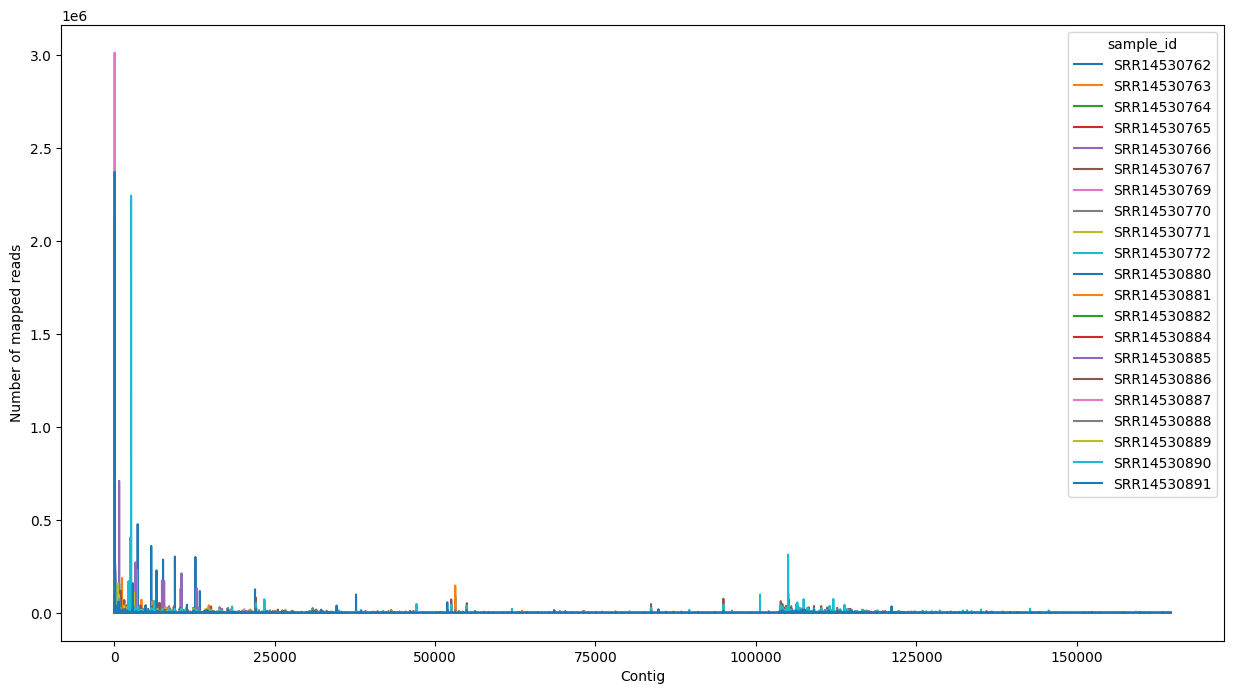

In [181]:
# Set the figure size
rcParams['figure.figsize'] = 15, 8

# n_samples = len(counts_df.columns)
# cm = plt.get_cmap('gist_rainbow')
# colors = [cm(1.*i/n_samples) for i in range(n_samples)]

ax = counts_df.plot(xlabel='Contig', ylabel='Number of mapped reads')

Generate a heatmap for the N longest contigs

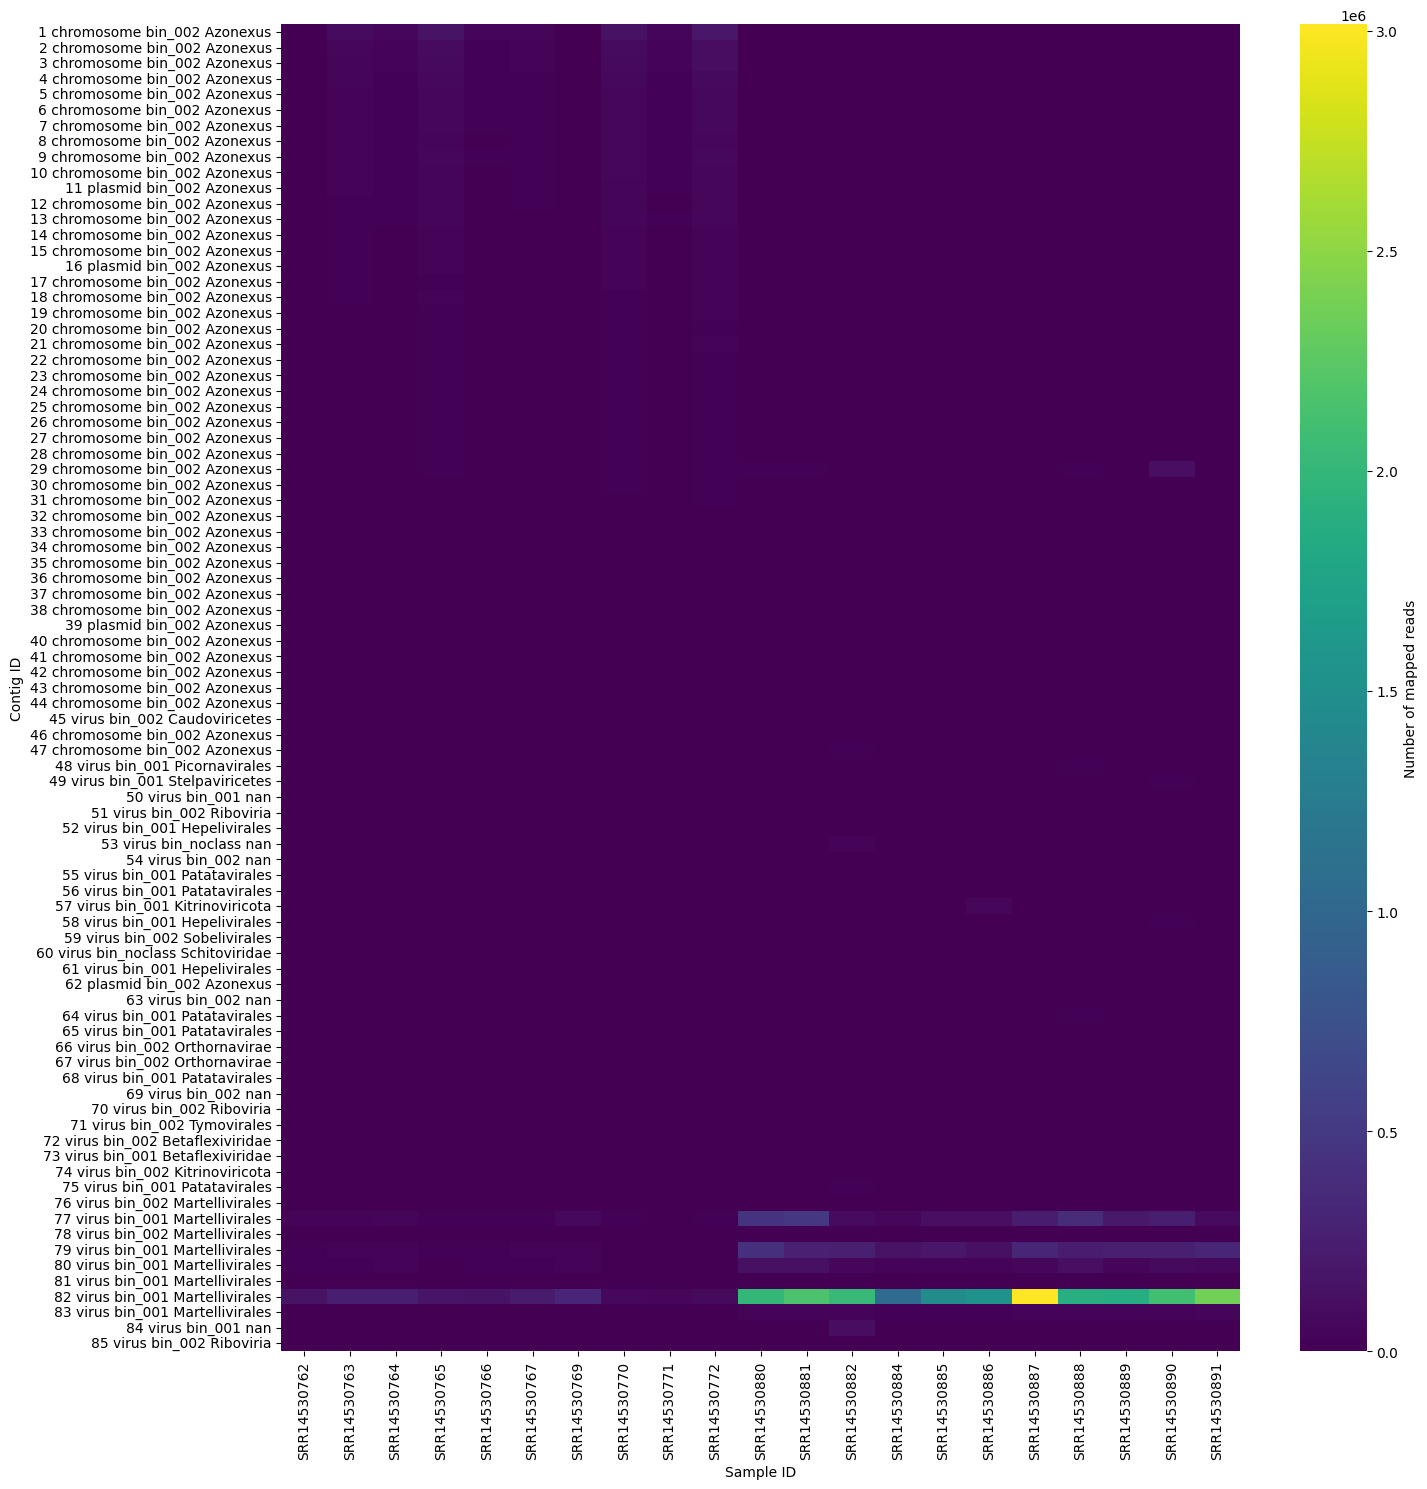

In [182]:
n = 85
top_contigs_df = counts_df.head(n)

# Generate a list of contig labels consisting of the contig ID, the prediction, bin and taxonomic classification
top_contig_labels = []
for index, row in df.head(n).iterrows():
    # index
    # Get the index of the max value in the scores
    predictions = ['chromosome', 'plasmid', 'virus']
    scores = [row.chromosome_score, row.plasmid_score, row.virus_score]
    max_score = max(scores)
    max_index = scores.index(max_score)
    prediction = predictions[max_index]
    bin = ''
    if row.bin_id != 'NA':
        bin = f'bin_{row.bin_id}'
    if prediction != 'virus':
        tax = str(row.classification).split(';')[-2].split('__')[-1]
    else:
        tax = str(row.lineage).split(';')[-1]
    top_contig_labels.append(f'{index} {prediction} {bin} {tax}')

plt.figure(figsize=(15, 15))

ax =sns.heatmap(top_contigs_df, cmap='viridis', cbar_kws={'label': 'Number of mapped reads'}, yticklabels=top_contig_labels)
ax.set_xlabel('Sample ID')
ax.set_ylabel('Contig ID')

plt.tight_layout()